In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import cv2
import math
import sklearn.datasets as dataset
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def GD_univariate_gaussian(iterations,P_em,K,clas):

    """GMM ALGORITHM
    Input : 
    iterations -- Maximum no. of iterations
    P_em       -- dictionary that contains mean, variances and weightages of all mixture components
    K          -- no. of mixture components
    clas       -- input data
    Return: 
    P_em -- Updated dictionary that contains mean, variances and weightages of all mixture components
    res_coeff  -- contains the responsibility coefficient of all images w.r.t each mixture
    log_likey  -- contains log likelihood of each iteration
    
    """
    
    
    ll_old=0
    ll_new=0
    log_likely= np.zeros((iterations,1))
    
    for itr in range(iterations):  
        #responsibility coefficient of size(no. of images in a clas x mixture components)
        res_coeff=np.zeros((len(clas),K))  
        
        for n in range(len(clas)):
            res_coeff_nr=np.zeros((1,K))       #to store respob. coeff of each mixture component
            xn=clas[n]
            for k in range(K):
                
                #store the mean and variance of kth mixture component 
                mu=P_em["mean"+str(k)] 
                var=P_em["variance"+str(k)]
                var=np.abs(var)
                var_inv=1/(var+0.01) #added 0.01 to avoid 'nan'(undefined)  np.linalg.inv(var)
                
                #(1/(2*pi*var)^(1/2))*exp(-x^2/(2*var))
                fx_pi=1/(np.sqrt(2*np.pi*(var+0.01)))
                fx_var=(1/(np.sqrt(var+0.01)))
                muSmu=((xn-mu)*(xn-mu)*var_inv)/2
                f_x_k=fx_pi*np.exp(-muSmu)  
                
                #gamma_nk numerator=lamda_k*gaussian(x_n,theta_k)
                
                res_coeff_nr[0,k]=P_em["lamda"][k]*f_x_k 
            
            # respob. coeff of nth input w.r.t kth mixture
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            res_coeff[n,:]=res_coeff_nr/(np.sum(res_coeff_nr)+1e-50) 

        #EXPECTATION - STEP
        
        #sum of gamma_nk over-all n for each k
        N_k=np.sum(res_coeff,axis=0) 
        eta=0.01
        for k in range(K):
            
            res_coeff_k=res_coeff[:,k]
            res_coeff_k=np.reshape(res_coeff_k,(1,len(clas)))
            
            #MAXIMISATION - STEP
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            
            #mean=(sum(gamma_nk*x_n))(over all n)/sum(gamma_nk) (over all n)
            mu_k=P_em["mean"+str(k)]
            var_k=P_em["variance"+str(k)]
            delta_mu=(res_coeff_k@(clas[:]-mu_k))/(var_k+1e-50)
            P_em["mean"+str(k)]=P_em["mean"+str(k)]+eta*delta_mu
            
            mu_k=P_em["mean"+str(k)]
            
            x_mu=(clas[:]-mu_k)
            x_mu=(np.square(x_mu)/var_k)-1
            #var= (sum(gamma_nk*(x_n-mean_k)^2)(over all n)/sum(gamma_nk) (over all n)
            var_temp=(res_coeff_k@x_mu)/np.sqrt(var_k)  
            var_temp=np.array(var_temp)
            # var_temp=np.abs(var_temp*var_temp)
            
            #update variance of kth mixture component
            P_em["variance"+str(k)]=P_em["variance"+str(k)]+eta*var_temp #(res_coeff_k@(var_temp))/(N_k[k]+1e-10)
            
         
        
        #update lamda
        P_em["lamda"]=N_k/len(clas)


        """Below code is find the log likelihood for the parameters obtained in the current iteration"""


        ll=0
        for n in range(len(clas)):
            xi=clas[n]
            lh=0
          
            for k in range(K):
                #store the mean and variance of kth mixture component 
                mu=P_em["mean"+str(k)] 
                var=P_em["variance"+str(k)]
                var=np.abs(var)
                var_inv=1/(var+0.01) #added 0.01 to avoid 'nan'(undefined)  np.linalg.inv(var)
                
                #(1/(2*pi*var)^(1/2))*exp(-x^2/(2*var))
                fx_pi=1/(np.sqrt(2*np.pi*(var+0.01)))
                fx_var=(1/(np.sqrt(var+0.01)))
                muSmu=((xi-mu)*(xi-mu)*var_inv)/2
                f_x_k=fx_pi*np.exp(-muSmu)  
                
                #gamma_nk numerator=lamda_k*gaussian(x_n,theta_k)
                
                lh=lh+P_em["lamda"][k]*f_x_k 

            ll=ll+np.log(lh)
        ll_old=ll_new
        ll_new=ll
        log_likely[itr]=ll_new


        
        if (np.abs(ll_new-ll_old)<0.1 and itr>=1):
            #log_likely[itr+1:iterations]=log_likely[itr]
            print(f"For iteration {itr} the difference between new log likelihood and old log likelihood is less than 0.1")
            break
    
    return log_likely,P_em,res_coeff,itr



### Gradient Ascent for Univariate Gaussian Mixture Model

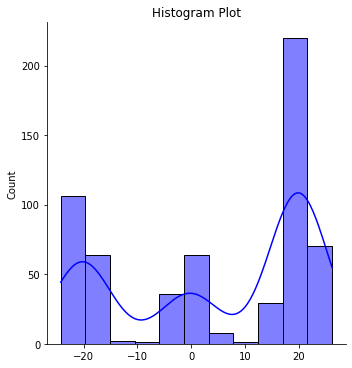

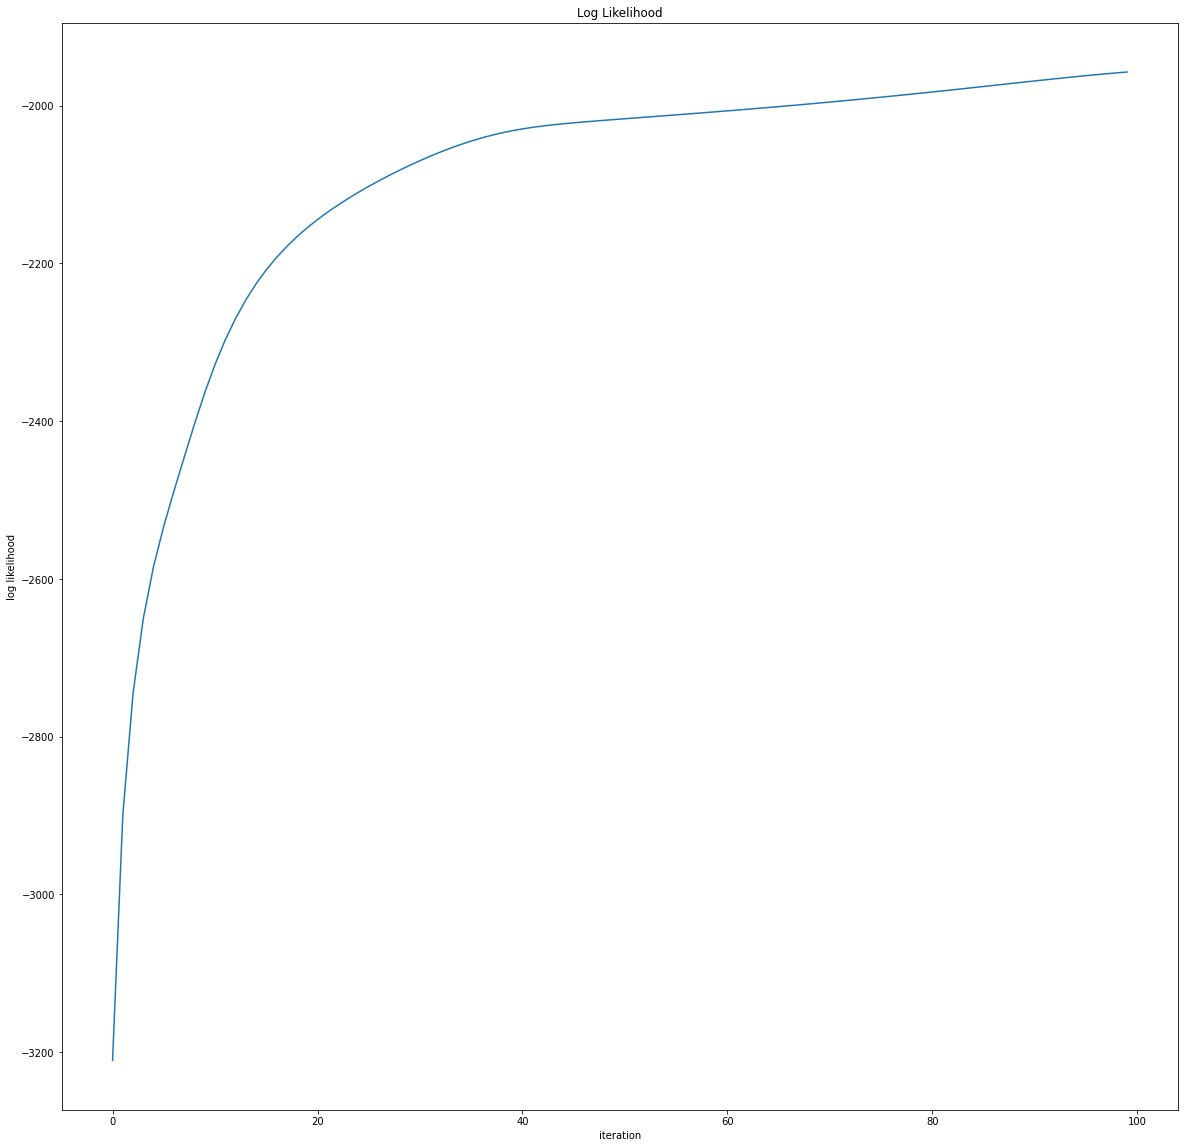

For component 0  true mean is -20.0: and variance is 5
For component 1  true mean is 0.0: and variance is 10
For component 2  true mean is 20.0: and variance is 5
For component 0 mean is : -0.23002892389027785 , variance is : 7.163082086462582 and the weight is : 0.18287282570234714
For component 1 mean is : -20.168505668621314 , variance is : 6.972120366100966 and the weight is : 0.2861898476978017
For component 2 mean is : 19.92973365408865 , variance is : 4.972749996681182 and the weight is : 0.5309373265998513


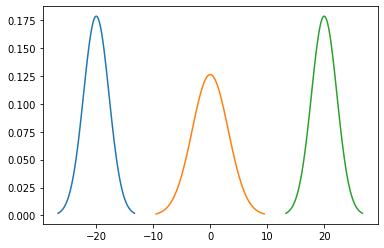

In [11]:

K = 3     # Number of mixture components in univariate GMM 
N = 600 # Number of samples to be drawn from univariate GMM
iterations=100
means     = np.linspace(-20, 20, num=K)
variances = np.array([5,10,5])#np.linspace(3,6, num=K)
lambdas   = [0.3,0.2,0.5]

samples_lst=0
for n in range(N):
    mix_no=np.random.choice(3,p=lambdas)
    sample= np.random.normal(loc = means[mix_no],scale = np.sqrt(variances[mix_no]))
    samples_lst=np.append(samples_lst,sample)
#     samples_lst= [np.random.normal(loc = means[k],scale = np.sqrt(variances[k]),size = int(N//2)) for k in range(K)]
#     samples     = np.expand_dims(np.array([item for sublist in samples_lst for item in sublist]),axis=1)
sns.displot(samples_lst, color='b',kde=True)   #kde=True give the denstity estimate using histogram method
plt.hist(samples_lst, bins =10,density=True)
plt.title("Histogram Plot")
plt.show()

P=dict()

#initialise lamda's=1/K
phi=np.ones((1,K))*(1/K)  #np.random.dirichlet(alpha)  #to genereate lamda values such that they sum to 1
P["lamda"]=phi [0,:]       #pi[0,:]

#random initialisation of mean and variance
for k in range(K):
    P["mean"+str(k)]= -20+40*np.random.rand()
    P["variance"+str(k)]= 5+ 5*np.random.rand()

# print(samples.shape)
# print(means.shape)
# print(variances.shape)
log_likely,P,res_coeff,itera=GD_univariate_gaussian(iterations,P,K,samples_lst)
plt.figure(figsize=(20,20))
plt.title("Log Likelihood")
#plt.axis('off')

plt.plot(log_likely)#plt.plot(np.linspace(1,iter_convg,iter_convg),log_likehood[:iter_convg])  #np.linspace(1,iterations,iterations),
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

for i in range(K):
    print(f"For component {i}  true mean is {means[i]}: and variance is {variances[i]}")
#     print(np.squeeze(P["mean"+str(i)]),end=' , variance is : ')
#     print(np.squeeze(P["variance"+str(i)]),end=' and the weight is : ')
#     print(np.squeeze(P["lamda"][i]))


for i in range(K):
    print(f"For component {i} mean is : ",end='')
    print(np.squeeze(P["mean"+str(i)]),end=' , variance is : ')
    print(np.squeeze(P["variance"+str(i)]),end=' and the weight is : ')
    print(np.squeeze(P["lamda"][i]))


for i in range(K):
  mu=means[i]
  sigma = np.sqrt(variances[i])
  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stat.norm.pdf(x, mu, sigma))
plt.show()